### Load dependencies and data files

In [8]:
library(data.table)
library(parallel)
load('../data/genomes/hg38/exonicvsnon_counts.rda') # Probabilities of each mutation type
load('../data/genomes/hg38/gene_pd_exon.rda') # Load tables giving probability of insertion for each gene in a diploid genome for both genders
source('./src_sompop_v0_2_5.r')
xy_genes <- gene_pd_m$gene_id[gene_pd_m$chrom %in% c('X','Y')] # Getting list of genes on chroms. X and Y by symbol

### Set the file containing a list of driver genes (by Ensembl ID)

In [9]:
geneListFile <- '../data/gene_lists/drivers_lusc_filt.txt'

In [10]:
### Check the list
geneList <- read.csv(geneListFile,header=F)
geneList <- geneList$V1
gene_pd_m[gene_pd_m$gene_id %in% geneList]

chrom,gene_id,counts,length,type,gene_sym,p
2,ENSG00000115414,323.59505,17315,0,FN1,1.744294e-04
1,ENSG00000117713,253.21151,15928,0,ARID1A,1.388633e-04
13,ENSG00000139687,190.07949,6452,0,RB1,9.875020e-05
17,ENSG00000141510,119.49962,5688,0,TP53,6.371016e-05
9,ENSG00000147889,52.38117,4329,0,CDKN2A,2.975770e-05
9,ENSG00000148400,76.60065,10377,0,NOTCH1,4.755304e-05
12,ENSG00000167548,154.64003,20485,0,KMT2D,9.553649e-05
10,ENSG00000171862,356.45673,11581,0,PTEN,1.846694e-04
17,ENSG00000196712,806.26957,27130,0,NF1,4.186364e-04


### Define other parameters

In [13]:
###################################################3
# Gender of organism
gender <- 'male'

# Ensembl ID of driver gene disrupted at t=0
driverGene <- ''
driverGene <- 'ENSG00000141510' # TP53

# Initial number of cells
N0 <- 1e3

# Average # L1 insertions / cell cycle
mu <- 1

# Selective strengths of each mutation type
spd <- 0.1 # Homozygous driver
spp <- 0.005 # Homozygous passenger
sld <- spd*0.1 # Heterozygous driver
slp <- spp*0.1 # Hetero. passenger

# Number of time steps to simulate
NT <- 5e3

####################################################
# Parallel processing (mcmapply())
parallel <- FALSE

# Time resolution: number of generations simulated per timestep (can be < 1)
tau <- 1

# Buffer size of population data object; represents the max possible number of clones in the population
maxNClones <- N0*4
# Log path
logpath <- './log.txt'

## Test run

    user   system  elapsed 
3486.129    2.171  778.368 


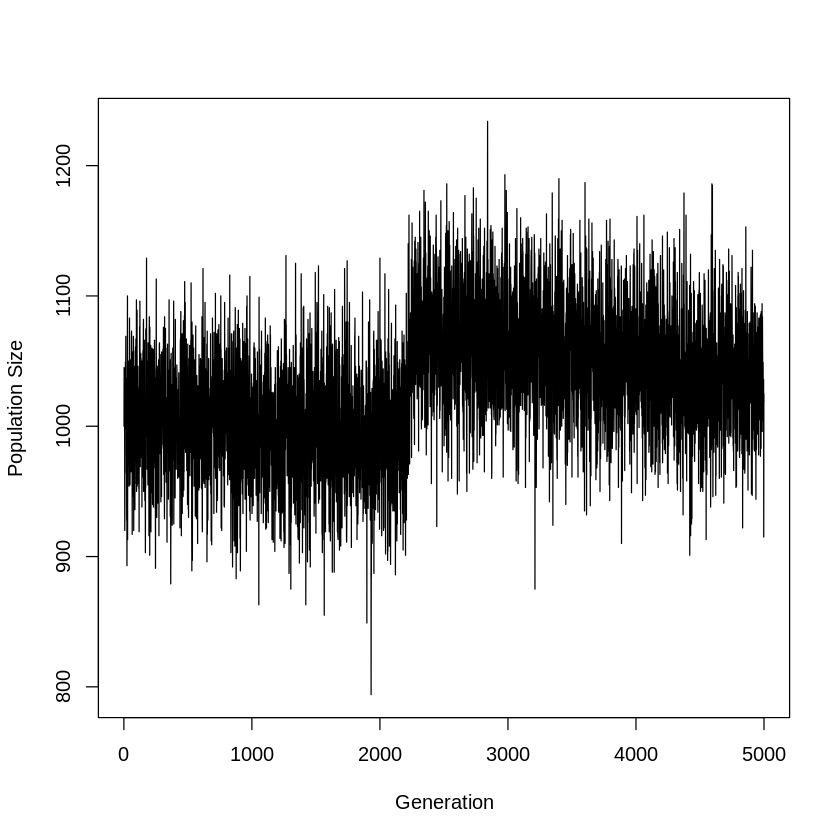

In [15]:
out <- sompop(N0, mu, tau, NT, sld, slp, spd, spp, gender, driverGene, geneListFile, maxNClones, logpath, 'single', parallel)
Pop <- out[[1]]
N <- out[[2]]
genTime <- out[[4]]

# head(Pop)
N[N==0] <- NA
genTime[genTime==0] <- NA
plot(1:NT*tau,N,type='l',xlab='Generation',ylab='Population Size')

## Batch run - random sample conditions

In [ ]:
# Static parameters
sd <- .1
sp <- .005
hef <- 0.1 # Fraction of homozygous effect assigned to heterozygous mutations
parallel <- FALSE # Whether to use parallel processing

nrep <- 10 # Number of replicates for each sampled condition
Ns <- 100 # Number of random conditions to sample and simulate
outPath <- '../data/output/test' # Output file
logPath <- paste0(outPath,'run.log') # Log file
system(paste0('rm ',logPath))

nrun <- 0
tryCatch({

    for (ii in 1:Ns) {
        
        # Sample random N0 (10 - 2500)
        N0 <- sample(seq(10,25e2,10),1)
        
        # Sample random mu (0.01 - 6)
        mu <- sample(seq(0.01,6,0.05),1)
        
        # Perform replicates
        for (nn in 1:nrep) {
            nrun <- nrun+1
            line <- paste0('\nRun: ',toString(nrun),'\tN0: ',toString(N0),'\tmu: ',toString(mu),'\tsd: ',toString(sd),'\tsp: ',toString(sp))
            write(line,file=logPath,append=TRUE)
            out <- sompop(N0, mu, tau, NT, sd*hef, sp*hef, sd, sp, gender, driverGene, geneListFile, N0*4, logPath, 'none', parallel)
            Pop <- out[[1]]
            N <- out[[2]]
            mut_genes <- out[[3]]
            gen_time <- out[[4]]
            save(N0,mu,Pop,N,mut_genes,gen_time,file=paste0(outPath,'run_n0',N0,'_',nrun,".rda"))
            rm(Pop,N,mut_genes,gen_time)
        }
    }

    }, warning = function(warn.msg){
        write(toString(warn.msg), logPath, append=TRUE)
    }, error = function(err.msg){
        write(toString(err.msg), logPath, append=TRUE)
    }
)